In [23]:
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.metrics import roc_auc_score, average_precision_score, RocCurveDisplay

import scikitplot as skplt
from scikitplot.helpers import binary_ks_curve

import optuna
from optuna.trial import TrialState
import pickle

##### Carregando o dataset

In [3]:
df_train = pd.read_csv('../data/treated_data/train.csv')
df_val = pd.read_csv('../data/treated_data/validation.csv')
df_test = pd.read_csv('../data/treated_data/test.csv')

In [4]:
X_train = df_train.drop(['satisfaction'], axis=1)
y_train = df_train['satisfaction'].values

X_val = df_val.drop(['satisfaction'], axis=1)
y_val = df_val['satisfaction'].values

X_test = df_test.drop(['satisfaction'], axis=1)
y_test = df_test['satisfaction'].values

#### Declarando as funções de avaliação do modelo

In [5]:
def plot_roc_curve(y_pred: np.array, y_test: np.array) -> None:
    
    # Obter as probabilidades da classe positiva
    y_pred_positive = y_pred[:, 1]
    
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_positive)
    roc_auc = roc_auc_score(y_test, y_pred_positive)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})' )
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()



In [6]:
def plot_confusion_matrix(y_pred: np.array, y_test: np.array) -> None:
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Unsatisfied', 'Satisfied'], yticklabels=['Unsatisfied', 'Satisfied'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

In [7]:
def compute_performance_metrics(y, y_pred_class, y_pred_scores=None):
    accuracy = accuracy_score(y, y_pred_class)
    recall = recall_score(y, y_pred_class)
    precision = precision_score(y, y_pred_class)
    f1 = f1_score(y, y_pred_class)
    performance_metrics = (accuracy, recall, precision, f1)
    if y_pred_scores is not None:
        skplt.metrics.plot_ks_statistic(y, y_pred_scores)
        plt.show()
        y_pred_scores = y_pred_scores[:, 1]
        auroc = roc_auc_score(y, y_pred_scores)
        aupr = average_precision_score(y, y_pred_scores)
        performance_metrics = performance_metrics + (auroc, aupr)
    return performance_metrics

In [8]:
def print_metrics_summary(accuracy, recall, precision, f1, auroc=None, aupr=None):
    print()
    print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy))
    print("{metric:<18}{value:.4f}".format(metric="Recall:", value=recall))
    print("{metric:<18}{value:.4f}".format(metric="Precision:", value=precision))
    print("{metric:<18}{value:.4f}".format(metric="F1:", value=f1))
    if auroc is not None:
        print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=auroc))
    if aupr is not None:
        print("{metric:<18}{value:.4f}".format(metric="AUPR:", value=aupr))

##### Ajustando variáveis one-hot-encoding para string

In [9]:
columns_to_concat = [
    'Age',
    'Flight Distance',
    'Departure Delay in Minutes',
    'Arrival Delay in Minutes',
    'Gender',
    'Customer Type',
    'Type of Travel',
    'Class'
]

In [10]:
def one_hot_to_string(df: pd.DataFrame, col: list) -> pd.DataFrame:
    for prefix in col:
        cols_to_concat = [c for c in df.columns if c.startswith(prefix + '_')]
        
        if cols_to_concat:
            df[prefix] = df[cols_to_concat].astype(str).agg(''.join, axis=1)
            
            df.drop(cols_to_concat, axis=1, inplace=True)
            
    return df

In [11]:
X_train = one_hot_to_string(df=X_train, col=columns_to_concat)
X_val = one_hot_to_string(df=X_val, col=columns_to_concat)
X_test = one_hot_to_string(df=X_test, col=columns_to_concat)

In [12]:
X_train.columns

Index(['Inflight wifi service', 'Departure/Arrival time convenient',
       'Ease of Online booking', 'Gate location', 'Food and drink',
       'Online boarding', 'Seat comfort', 'Inflight entertainment',
       'On-board service', 'Leg room service', 'Baggage handling',
       'Checkin service', 'Inflight service', 'Cleanliness', 'Age',
       'Flight Distance', 'Departure Delay in Minutes',
       'Arrival Delay in Minutes', 'Gender', 'Customer Type', 'Type of Travel',
       'Class'],
      dtype='object')

#### Retirando features com alta correlação e que não possuem tanta relevância

Age, Gate Location, Gender, Departure Delay in Minutes (Alta correlação com Arrival Dealy in minutes), Departure/Arrival time convenient

In [13]:
X_train = X_train.drop(['Age', 'Gate location', 'Gender', 'Departure Delay in Minutes', 'Departure/Arrival time convenient'], axis=1)
X_val = X_val.drop(['Age', 'Gate location', 'Gender', 'Departure Delay in Minutes', 'Departure/Arrival time convenient'], axis=1)
X_test = X_test.drop(['Age', 'Gate location', 'Gender', 'Departure Delay in Minutes', 'Departure/Arrival time convenient'], axis=1)


In [14]:
X_train = X_train.values
X_val = X_val.values
X_test = X_test.values

##### Criando o modelo xgboost base

Utilizaremos configurações similares a configuração base do random forest, para comparação

In [15]:
params = {
    'max_depth': 10,
    'eta': 0.1,  #Learning Rate
    'objective': 'binary:logistic', # Escolha para classificação binária
    'eval_metric': 'auc',            # Avaliando via AUC
    'seed' : 51
}

##### Criando instância DMatrix

In [16]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

In [18]:
model = xgb.train(params, dtrain, 50, evals=[(dval, 'validation')], early_stopping_rounds=5)


[0]	validation-auc:0.98693
[1]	validation-auc:0.98721
[2]	validation-auc:0.98790
[3]	validation-auc:0.98866
[4]	validation-auc:0.98880
[5]	validation-auc:0.98891
[6]	validation-auc:0.98909
[7]	validation-auc:0.98931
[8]	validation-auc:0.98948
[9]	validation-auc:0.98979
[10]	validation-auc:0.98997
[11]	validation-auc:0.99021
[12]	validation-auc:0.99031
[13]	validation-auc:0.99055
[14]	validation-auc:0.99064
[15]	validation-auc:0.99093
[16]	validation-auc:0.99107
[17]	validation-auc:0.99119
[18]	validation-auc:0.99127
[19]	validation-auc:0.99138
[20]	validation-auc:0.99143
[21]	validation-auc:0.99152
[22]	validation-auc:0.99161
[23]	validation-auc:0.99172
[24]	validation-auc:0.99179
[25]	validation-auc:0.99184
[26]	validation-auc:0.99189
[27]	validation-auc:0.99199
[28]	validation-auc:0.99204
[29]	validation-auc:0.99210
[30]	validation-auc:0.99214
[31]	validation-auc:0.99219
[32]	validation-auc:0.99224
[33]	validation-auc:0.99232
[34]	validation-auc:0.99239
[35]	validation-auc:0.99242
[3

#### Avaliando o Modelo


In [19]:
xgb_pred_scores = model.predict(dtest)

# Calculando a probabilidade da classe negativa
neg_class_probs = 1 - xgb_pred_scores

# Concatenando as duas arrays para formar um array 2D
xgb_pred_scores = np.vstack((neg_class_probs, xgb_pred_scores)).T
xgb_pred_class = np.argmax(xgb_pred_scores, axis=1)

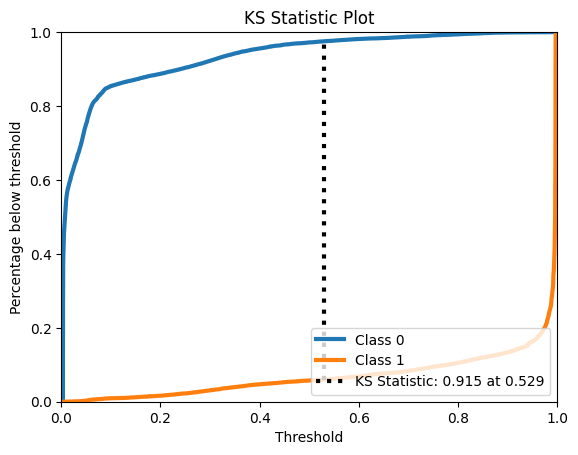



xgboost - Test

Accuracy:         0.9592
Recall:           0.9424
Precision:        0.9628
F1:               0.9525
AUROC:            0.9934
AUPR:             0.9924


In [20]:
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_test, xgb_pred_class, xgb_pred_scores)
print('\n\nxgboost - Test')
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

#### Usando o Optune para encontrar os melhores Hiperparâmetros

In [24]:
def objective(trial):

    global dtrain
    global dval
    global dtest
    global y_test

    params = {
        'max_depth': trial.suggest_int('max_depth', 3,  50),
        'eta': trial.suggest_discrete_uniform('eta', 0.05,  0.3, 0.05),  #Learning Rate
        'objective': 'binary:logistic', # Escolha para classificação binária
        'eval_metric': 'auc',        # Avaliando via AUC
        'lambda' : trial.suggest_int('lambda', 1,  5), # L2 regularization term on weights
        'alpha' : trial.suggest_int('alpha', 1,  5),
        'grow_policy' : trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide']),
        'seed' : 51,
    }



    trial.set_user_attr("max_depth", params["max_depth"])
    trial.set_user_attr("eta", params["eta"])
    trial.set_user_attr("lambda", params["lambda"])
    trial.set_user_attr("alpha", params["alpha"])
    trial.set_user_attr("grow_policy", params["grow_policy"])

    
    # Criar o modelo RandomForest com os hiperparâmetros sugeridos
    model = xgb.train(params, dtrain, 100, evals=[(dval, 'validation')], early_stopping_rounds=5)

    
    xgb_pred_scores = model.predict(dtest)

    neg_class_probs = 1 - xgb_pred_scores

    xgb_pred_scores = np.vstack((neg_class_probs, xgb_pred_scores)).T
    xgb_pred_class = np.argmax(xgb_pred_scores, axis=1)

    thresholds, pct1, pct2, ks_statistic, \
        max_distance_at, classes = binary_ks_curve(y_test, xgb_pred_scores[:, 1].ravel())

    accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_test, xgb_pred_class, xgb_pred_scores)
    print(f'\n\nXgboost\neta: {params["eta"]}\nmax_depth:{params["max_depth"]}\nlambda:{params["lambda"]}\nalpha:{params["alpha"]}\ngrow_policy:{params["grow_policy"]}')
    print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)
    

    trial.set_user_attr("accuracy", accuracy)
    trial.set_user_attr("recall", recall)
    trial.set_user_attr("precision", precision)
    trial.set_user_attr("f1", precision)
    trial.set_user_attr("auroc", auroc)
    trial.set_user_attr("ks_statistic", ks_statistic)
    trial.set_user_attr("max_distance_at", max_distance_at)
    
    pickle.dump(model, open(f'../models/xgb_{trial.number}.pkl', 'wb'))

    return auroc, ks_statistic


[I 2024-07-30 13:48:20,642] A new study created in memory with name: no-name-33fd92df-bef5-48cc-ae22-6b15361679b9


[0]	validation-auc:0.98318
[1]	validation-auc:0.98505
[2]	validation-auc:0.98885


/tmp/ipykernel_28613/3117608483.py:10: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'eta': trial.suggest_discrete_uniform('eta', 0.05,  0.3, 0.05),  #Learning Rate


[3]	validation-auc:0.98940
[4]	validation-auc:0.98969
[5]	validation-auc:0.98987
[6]	validation-auc:0.99014
[7]	validation-auc:0.99054
[8]	validation-auc:0.99076
[9]	validation-auc:0.99099
[10]	validation-auc:0.99127
[11]	validation-auc:0.99143
[12]	validation-auc:0.99152
[13]	validation-auc:0.99187
[14]	validation-auc:0.99202
[15]	validation-auc:0.99215
[16]	validation-auc:0.99233
[17]	validation-auc:0.99249
[18]	validation-auc:0.99260
[19]	validation-auc:0.99270
[20]	validation-auc:0.99277
[21]	validation-auc:0.99284
[22]	validation-auc:0.99293
[23]	validation-auc:0.99300
[24]	validation-auc:0.99307
[25]	validation-auc:0.99312
[26]	validation-auc:0.99317
[27]	validation-auc:0.99326
[28]	validation-auc:0.99332
[29]	validation-auc:0.99336
[30]	validation-auc:0.99341
[31]	validation-auc:0.99346
[32]	validation-auc:0.99349
[33]	validation-auc:0.99352
[34]	validation-auc:0.99355
[35]	validation-auc:0.99358
[36]	validation-auc:0.99361
[37]	validation-auc:0.99363
[38]	validation-auc:0.99364

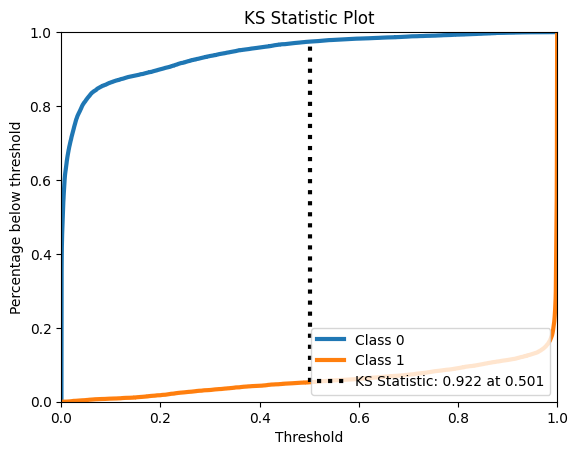

[I 2024-07-30 13:48:24,058] Trial 0 finished with values: [0.9943842646589154, 0.9221286276947882] and parameters: {'max_depth': 36, 'eta': 0.15000000000000002, 'lambda': 4, 'alpha': 4, 'grow_policy': 'depthwise'}. 




Xgboost
eta: 0.15000000000000002
max_depth:36
lambda:4
alpha:4
grow_policy:depthwise

Accuracy:         0.9626
Recall:           0.9476
Precision:        0.9658
F1:               0.9566
AUROC:            0.9944
AUPR:             0.9935
[0]	validation-auc:0.98797
[1]	validation-auc:0.98827
[2]	validation-auc:0.98934


/tmp/ipykernel_28613/3117608483.py:10: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'eta': trial.suggest_discrete_uniform('eta', 0.05,  0.3, 0.05),  #Learning Rate


[3]	validation-auc:0.98941
[4]	validation-auc:0.98949
[5]	validation-auc:0.98970
[6]	validation-auc:0.99001
[7]	validation-auc:0.99007
[8]	validation-auc:0.99021
[9]	validation-auc:0.99035
[10]	validation-auc:0.99051
[11]	validation-auc:0.99061
[12]	validation-auc:0.99081
[13]	validation-auc:0.99138
[14]	validation-auc:0.99147
[15]	validation-auc:0.99168
[16]	validation-auc:0.99183
[17]	validation-auc:0.99200
[18]	validation-auc:0.99207
[19]	validation-auc:0.99215
[20]	validation-auc:0.99220
[21]	validation-auc:0.99232
[22]	validation-auc:0.99242
[23]	validation-auc:0.99249
[24]	validation-auc:0.99257
[25]	validation-auc:0.99263
[26]	validation-auc:0.99268
[27]	validation-auc:0.99273
[28]	validation-auc:0.99277
[29]	validation-auc:0.99279
[30]	validation-auc:0.99287
[31]	validation-auc:0.99292
[32]	validation-auc:0.99296
[33]	validation-auc:0.99300
[34]	validation-auc:0.99305
[35]	validation-auc:0.99307
[36]	validation-auc:0.99309
[37]	validation-auc:0.99313
[38]	validation-auc:0.99316

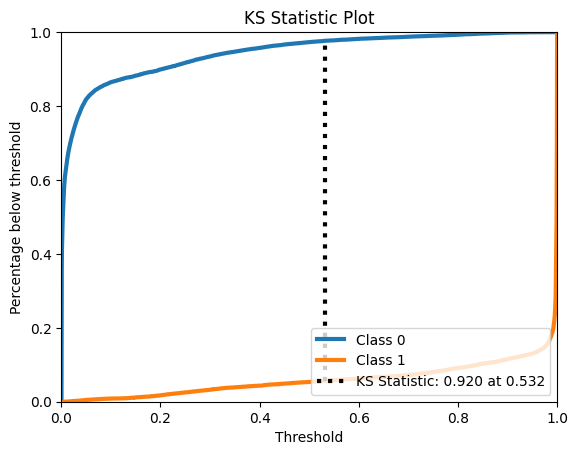

[I 2024-07-30 13:48:27,417] Trial 1 finished with values: [0.9943285199142807, 0.9203701194719451] and parameters: {'max_depth': 27, 'eta': 0.1, 'lambda': 1, 'alpha': 4, 'grow_policy': 'depthwise'}. 




Xgboost
eta: 0.1
max_depth:27
lambda:1
alpha:4
grow_policy:depthwise

Accuracy:         0.9614
Recall:           0.9465
Precision:        0.9640
F1:               0.9551
AUROC:            0.9943
AUPR:             0.9934
[0]	validation-auc:0.98782
[1]	validation-auc:0.98956
[2]	validation-auc:0.99012
[3]	validation-auc:0.99041


/tmp/ipykernel_28613/3117608483.py:10: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'eta': trial.suggest_discrete_uniform('eta', 0.05,  0.3, 0.05),  #Learning Rate


[4]	validation-auc:0.99089
[5]	validation-auc:0.99127
[6]	validation-auc:0.99167
[7]	validation-auc:0.99192
[8]	validation-auc:0.99242
[9]	validation-auc:0.99269
[10]	validation-auc:0.99277
[11]	validation-auc:0.99288
[12]	validation-auc:0.99297
[13]	validation-auc:0.99303
[14]	validation-auc:0.99313
[15]	validation-auc:0.99317
[16]	validation-auc:0.99328
[17]	validation-auc:0.99332
[18]	validation-auc:0.99339
[19]	validation-auc:0.99346
[20]	validation-auc:0.99350
[21]	validation-auc:0.99353
[22]	validation-auc:0.99358
[23]	validation-auc:0.99359
[24]	validation-auc:0.99361
[25]	validation-auc:0.99362
[26]	validation-auc:0.99366
[27]	validation-auc:0.99367
[28]	validation-auc:0.99365
[29]	validation-auc:0.99366
[30]	validation-auc:0.99365
[31]	validation-auc:0.99366
[32]	validation-auc:0.99366


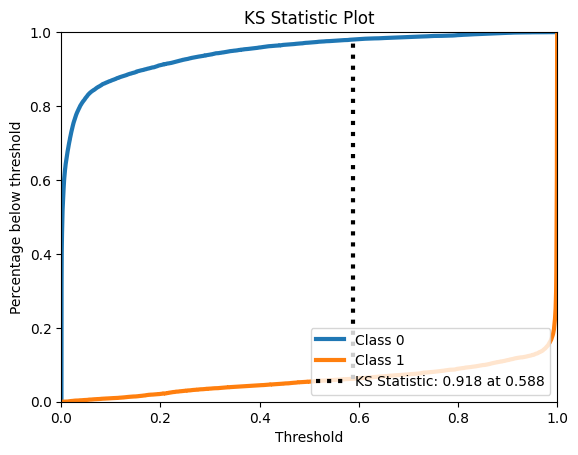

[I 2024-07-30 13:48:29,977] Trial 2 finished with values: [0.9942258666647859, 0.9182224731317994] and parameters: {'max_depth': 22, 'eta': 0.25, 'lambda': 3, 'alpha': 2, 'grow_policy': 'lossguide'}. 




Xgboost
eta: 0.25
max_depth:22
lambda:3
alpha:2
grow_policy:lossguide

Accuracy:         0.9603
Recall:           0.9458
Precision:        0.9622
F1:               0.9539
AUROC:            0.9942
AUPR:             0.9933
[0]	validation-auc:0.98321
[1]	validation-auc:0.98868
[2]	validation-auc:0.98949


/tmp/ipykernel_28613/3117608483.py:10: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'eta': trial.suggest_discrete_uniform('eta', 0.05,  0.3, 0.05),  #Learning Rate


[3]	validation-auc:0.99055
[4]	validation-auc:0.99097
[5]	validation-auc:0.99147
[6]	validation-auc:0.99201
[7]	validation-auc:0.99244
[8]	validation-auc:0.99274
[9]	validation-auc:0.99292
[10]	validation-auc:0.99302
[11]	validation-auc:0.99314
[12]	validation-auc:0.99329
[13]	validation-auc:0.99343
[14]	validation-auc:0.99349
[15]	validation-auc:0.99355
[16]	validation-auc:0.99358
[17]	validation-auc:0.99362
[18]	validation-auc:0.99363
[19]	validation-auc:0.99368
[20]	validation-auc:0.99374
[21]	validation-auc:0.99377
[22]	validation-auc:0.99376
[23]	validation-auc:0.99377
[24]	validation-auc:0.99379
[25]	validation-auc:0.99379
[26]	validation-auc:0.99382
[27]	validation-auc:0.99382
[28]	validation-auc:0.99383
[29]	validation-auc:0.99383
[30]	validation-auc:0.99382
[31]	validation-auc:0.99381
[32]	validation-auc:0.99379


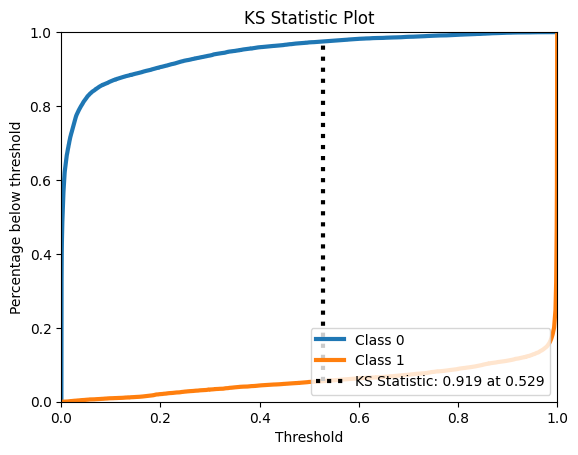

[I 2024-07-30 13:48:32,072] Trial 3 finished with values: [0.9943162730944093, 0.9193034938418724] and parameters: {'max_depth': 48, 'eta': 0.3, 'lambda': 5, 'alpha': 3, 'grow_policy': 'lossguide'}. 




Xgboost
eta: 0.3
max_depth:48
lambda:5
alpha:3
grow_policy:lossguide

Accuracy:         0.9611
Recall:           0.9466
Precision:        0.9632
F1:               0.9548
AUROC:            0.9943
AUPR:             0.9934
[0]	validation-auc:0.98726
[1]	validation-auc:0.98922


/tmp/ipykernel_28613/3117608483.py:10: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'eta': trial.suggest_discrete_uniform('eta', 0.05,  0.3, 0.05),  #Learning Rate


[2]	validation-auc:0.98965
[3]	validation-auc:0.99023
[4]	validation-auc:0.99072
[5]	validation-auc:0.99110
[6]	validation-auc:0.99153
[7]	validation-auc:0.99187
[8]	validation-auc:0.99238
[9]	validation-auc:0.99269
[10]	validation-auc:0.99278
[11]	validation-auc:0.99289
[12]	validation-auc:0.99305
[13]	validation-auc:0.99313
[14]	validation-auc:0.99326
[15]	validation-auc:0.99331
[16]	validation-auc:0.99336
[17]	validation-auc:0.99344
[18]	validation-auc:0.99347
[19]	validation-auc:0.99349
[20]	validation-auc:0.99352
[21]	validation-auc:0.99354
[22]	validation-auc:0.99359
[23]	validation-auc:0.99361
[24]	validation-auc:0.99362
[25]	validation-auc:0.99365
[26]	validation-auc:0.99366
[27]	validation-auc:0.99367
[28]	validation-auc:0.99368
[29]	validation-auc:0.99372
[30]	validation-auc:0.99371
[31]	validation-auc:0.99371
[32]	validation-auc:0.99372
[33]	validation-auc:0.99372
[34]	validation-auc:0.99373
[35]	validation-auc:0.99371
[36]	validation-auc:0.99371
[37]	validation-auc:0.99372


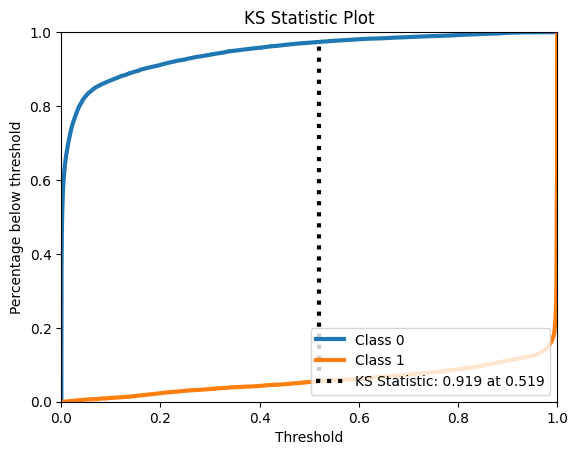

[I 2024-07-30 13:48:33,832] Trial 4 finished with values: [0.9942285206249629, 0.9192396212235608] and parameters: {'max_depth': 22, 'eta': 0.25, 'lambda': 4, 'alpha': 2, 'grow_policy': 'depthwise'}. 




Xgboost
eta: 0.25
max_depth:22
lambda:4
alpha:2
grow_policy:depthwise

Accuracy:         0.9609
Recall:           0.9470
Precision:        0.9625
F1:               0.9547
AUROC:            0.9942
AUPR:             0.9933
[0]	validation-auc:0.98791
[1]	validation-auc:0.98969
[2]	validation-auc:0.99019
[3]	validation-auc:0.99027


/tmp/ipykernel_28613/3117608483.py:10: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'eta': trial.suggest_discrete_uniform('eta', 0.05,  0.3, 0.05),  #Learning Rate


[4]	validation-auc:0.99053
[5]	validation-auc:0.99073
[6]	validation-auc:0.99120
[7]	validation-auc:0.99189
[8]	validation-auc:0.99221
[9]	validation-auc:0.99236
[10]	validation-auc:0.99249
[11]	validation-auc:0.99267
[12]	validation-auc:0.99282
[13]	validation-auc:0.99288
[14]	validation-auc:0.99295
[15]	validation-auc:0.99300
[16]	validation-auc:0.99304
[17]	validation-auc:0.99307
[18]	validation-auc:0.99309
[19]	validation-auc:0.99312
[20]	validation-auc:0.99315
[21]	validation-auc:0.99322
[22]	validation-auc:0.99324
[23]	validation-auc:0.99328
[24]	validation-auc:0.99330
[25]	validation-auc:0.99331
[26]	validation-auc:0.99335
[27]	validation-auc:0.99337
[28]	validation-auc:0.99339
[29]	validation-auc:0.99342
[30]	validation-auc:0.99343
[31]	validation-auc:0.99345
[32]	validation-auc:0.99346
[33]	validation-auc:0.99345
[34]	validation-auc:0.99345
[35]	validation-auc:0.99347
[36]	validation-auc:0.99347
[37]	validation-auc:0.99346
[38]	validation-auc:0.99346
[39]	validation-auc:0.9934

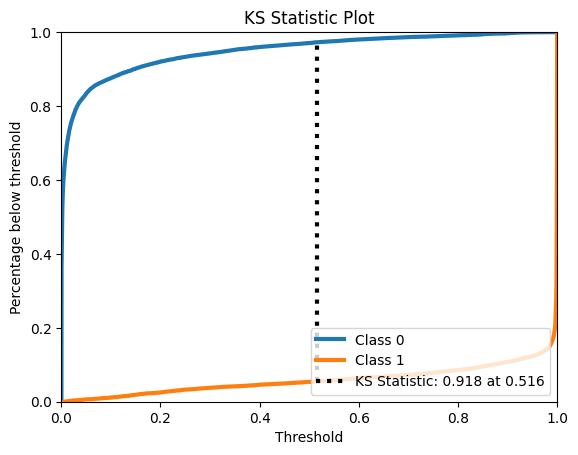

[I 2024-07-30 13:48:36,034] Trial 5 finished with values: [0.9941615867842217, 0.9178833568559132] and parameters: {'max_depth': 49, 'eta': 0.2, 'lambda': 3, 'alpha': 1, 'grow_policy': 'depthwise'}. 




Xgboost
eta: 0.2
max_depth:49
lambda:3
alpha:1
grow_policy:depthwise

Accuracy:         0.9601
Recall:           0.9464
Precision:        0.9611
F1:               0.9537
AUROC:            0.9942
AUPR:             0.9932


/tmp/ipykernel_28613/3117608483.py:10: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'eta': trial.suggest_discrete_uniform('eta', 0.05,  0.3, 0.05),  #Learning Rate


[0]	validation-auc:0.98776
[1]	validation-auc:0.98825
[2]	validation-auc:0.98908
[3]	validation-auc:0.98979
[4]	validation-auc:0.99006
[5]	validation-auc:0.99016
[6]	validation-auc:0.99022
[7]	validation-auc:0.99027
[8]	validation-auc:0.99035
[9]	validation-auc:0.99053
[10]	validation-auc:0.99059
[11]	validation-auc:0.99090
[12]	validation-auc:0.99114
[13]	validation-auc:0.99121
[14]	validation-auc:0.99137
[15]	validation-auc:0.99148
[16]	validation-auc:0.99168
[17]	validation-auc:0.99181
[18]	validation-auc:0.99191
[19]	validation-auc:0.99201
[20]	validation-auc:0.99234
[21]	validation-auc:0.99243
[22]	validation-auc:0.99257
[23]	validation-auc:0.99266
[24]	validation-auc:0.99277
[25]	validation-auc:0.99284
[26]	validation-auc:0.99290
[27]	validation-auc:0.99293
[28]	validation-auc:0.99296
[29]	validation-auc:0.99297
[30]	validation-auc:0.99301
[31]	validation-auc:0.99305
[32]	validation-auc:0.99307
[33]	validation-auc:0.99309
[34]	validation-auc:0.99312
[35]	validation-auc:0.99313
[3

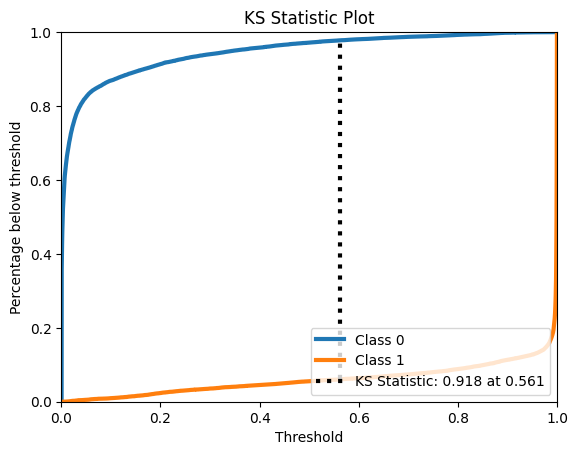

[I 2024-07-30 13:48:38,674] Trial 6 finished with values: [0.994165981742275, 0.9177454628755732] and parameters: {'max_depth': 31, 'eta': 0.1, 'lambda': 4, 'alpha': 1, 'grow_policy': 'depthwise'}. 




Xgboost
eta: 0.1
max_depth:31
lambda:4
alpha:1
grow_policy:depthwise

Accuracy:         0.9599
Recall:           0.9447
Precision:        0.9622
F1:               0.9534
AUROC:            0.9942
AUPR:             0.9932


/tmp/ipykernel_28613/3117608483.py:10: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'eta': trial.suggest_discrete_uniform('eta', 0.05,  0.3, 0.05),  #Learning Rate


[0]	validation-auc:0.98313
[1]	validation-auc:0.98851
[2]	validation-auc:0.98933
[3]	validation-auc:0.99034
[4]	validation-auc:0.99073
[5]	validation-auc:0.99128
[6]	validation-auc:0.99183
[7]	validation-auc:0.99221
[8]	validation-auc:0.99249
[9]	validation-auc:0.99263
[10]	validation-auc:0.99278
[11]	validation-auc:0.99296
[12]	validation-auc:0.99314
[13]	validation-auc:0.99324
[14]	validation-auc:0.99336
[15]	validation-auc:0.99343
[16]	validation-auc:0.99348
[17]	validation-auc:0.99355
[18]	validation-auc:0.99358
[19]	validation-auc:0.99361
[20]	validation-auc:0.99364
[21]	validation-auc:0.99367
[22]	validation-auc:0.99371
[23]	validation-auc:0.99373
[24]	validation-auc:0.99375
[25]	validation-auc:0.99375
[26]	validation-auc:0.99377
[27]	validation-auc:0.99378
[28]	validation-auc:0.99378
[29]	validation-auc:0.99379
[30]	validation-auc:0.99379
[31]	validation-auc:0.99379
[32]	validation-auc:0.99380
[33]	validation-auc:0.99380
[34]	validation-auc:0.99379
[35]	validation-auc:0.99379
[3

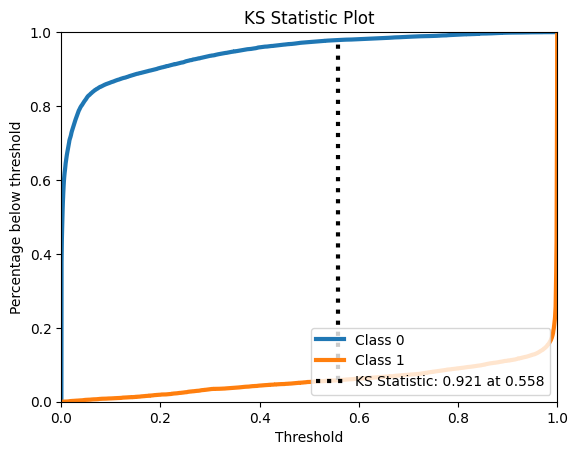

[I 2024-07-30 13:48:41,257] Trial 7 finished with values: [0.9943183094056723, 0.9209015870608513] and parameters: {'max_depth': 47, 'eta': 0.3, 'lambda': 5, 'alpha': 4, 'grow_policy': 'lossguide'}. 




Xgboost
eta: 0.3
max_depth:47
lambda:5
alpha:4
grow_policy:lossguide

Accuracy:         0.9615
Recall:           0.9466
Precision:        0.9642
F1:               0.9553
AUROC:            0.9943
AUPR:             0.9934
[0]	validation-auc:0.98406


/tmp/ipykernel_28613/3117608483.py:10: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'eta': trial.suggest_discrete_uniform('eta', 0.05,  0.3, 0.05),  #Learning Rate


[1]	validation-auc:0.98927
[2]	validation-auc:0.99006
[3]	validation-auc:0.99059
[4]	validation-auc:0.99117
[5]	validation-auc:0.99160
[6]	validation-auc:0.99184
[7]	validation-auc:0.99244
[8]	validation-auc:0.99264
[9]	validation-auc:0.99285
[10]	validation-auc:0.99295
[11]	validation-auc:0.99307
[12]	validation-auc:0.99315
[13]	validation-auc:0.99326
[14]	validation-auc:0.99334
[15]	validation-auc:0.99344
[16]	validation-auc:0.99348
[17]	validation-auc:0.99349
[18]	validation-auc:0.99356
[19]	validation-auc:0.99359
[20]	validation-auc:0.99362
[21]	validation-auc:0.99365
[22]	validation-auc:0.99366
[23]	validation-auc:0.99368
[24]	validation-auc:0.99369
[25]	validation-auc:0.99369
[26]	validation-auc:0.99367
[27]	validation-auc:0.99369
[28]	validation-auc:0.99367
[29]	validation-auc:0.99365
[30]	validation-auc:0.99364
[31]	validation-auc:0.99363
[32]	validation-auc:0.99363


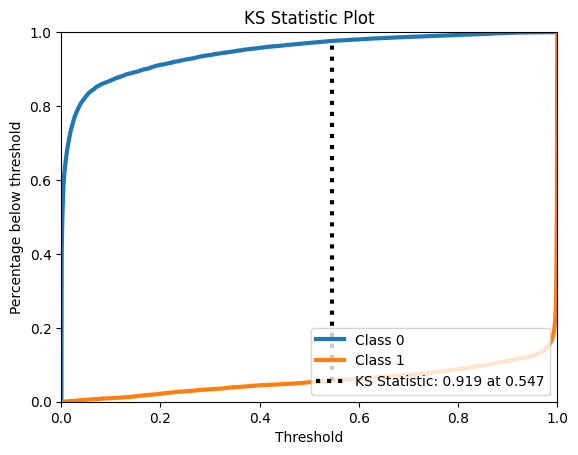

[I 2024-07-30 13:48:43,079] Trial 8 finished with values: [0.9942871297164361, 0.919481450074892] and parameters: {'max_depth': 37, 'eta': 0.3, 'lambda': 5, 'alpha': 2, 'grow_policy': 'depthwise'}. 




Xgboost
eta: 0.3
max_depth:37
lambda:5
alpha:2
grow_policy:depthwise

Accuracy:         0.9607
Recall:           0.9473
Precision:        0.9616
F1:               0.9544
AUROC:            0.9943
AUPR:             0.9934
[0]	validation-auc:0.98719
[1]	validation-auc:0.98868
[2]	validation-auc:0.98938


/tmp/ipykernel_28613/3117608483.py:10: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'eta': trial.suggest_discrete_uniform('eta', 0.05,  0.3, 0.05),  #Learning Rate


[3]	validation-auc:0.98999
[4]	validation-auc:0.99017
[5]	validation-auc:0.99030
[6]	validation-auc:0.99038
[7]	validation-auc:0.99068
[8]	validation-auc:0.99099
[9]	validation-auc:0.99160
[10]	validation-auc:0.99190
[11]	validation-auc:0.99207
[12]	validation-auc:0.99222
[13]	validation-auc:0.99231
[14]	validation-auc:0.99247
[15]	validation-auc:0.99259
[16]	validation-auc:0.99274
[17]	validation-auc:0.99280
[18]	validation-auc:0.99284
[19]	validation-auc:0.99288
[20]	validation-auc:0.99292
[21]	validation-auc:0.99298
[22]	validation-auc:0.99303
[23]	validation-auc:0.99307
[24]	validation-auc:0.99311
[25]	validation-auc:0.99314
[26]	validation-auc:0.99317
[27]	validation-auc:0.99324
[28]	validation-auc:0.99328
[29]	validation-auc:0.99332
[30]	validation-auc:0.99334
[31]	validation-auc:0.99337
[32]	validation-auc:0.99339
[33]	validation-auc:0.99340
[34]	validation-auc:0.99343
[35]	validation-auc:0.99346
[36]	validation-auc:0.99348
[37]	validation-auc:0.99349
[38]	validation-auc:0.99352

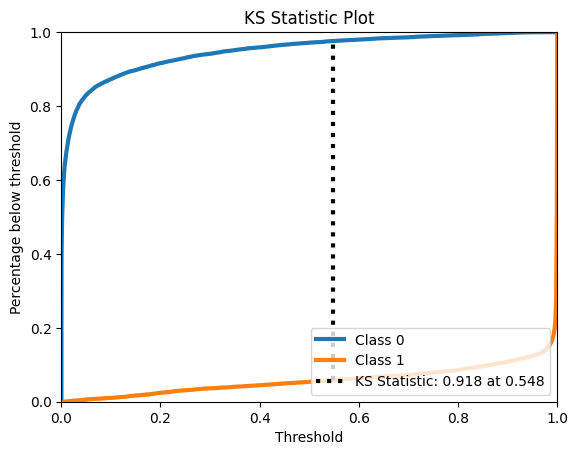

[I 2024-07-30 13:48:46,641] Trial 9 finished with values: [0.9942431145107073, 0.9178735748412388] and parameters: {'max_depth': 44, 'eta': 0.15000000000000002, 'lambda': 5, 'alpha': 1, 'grow_policy': 'depthwise'}. 




Xgboost
eta: 0.15000000000000002
max_depth:44
lambda:5
alpha:1
grow_policy:depthwise

Accuracy:         0.9604
Recall:           0.9461
Precision:        0.9621
F1:               0.9540
AUROC:            0.9942
AUPR:             0.9933


In [25]:
study = optuna.create_study(directions=['maximize', 'maximize'])
study.optimize(objective, n_trials=10)

#### Salvando os resultados no csv e visualizando os resultados

In [26]:
df = study.trials_dataframe()
df = df[df["state"] == "COMPLETE"].drop(["datetime_start", "datetime_complete", "duration", "state"], axis=1)
df = df.sort_values(['values_0', 'values_1']) 

csv_file = "../results/optuna_results_xgb_df2.csv"
df_existing = pd.read_csv(csv_file) if os.path.isfile(csv_file) else None

df_existing = pd.concat([df_existing, df], ignore_index=True) if df_existing is not None else df
df_existing.to_csv(csv_file, index=False)

In [27]:
df_existing

,number,values_0,values_1,params_alpha,params_eta,params_grow_policy,params_lambda,params_max_depth,user_attrs_accuracy,user_attrs_alpha,...,user_attrs_eta,user_attrs_f1,user_attrs_grow_policy,user_attrs_ks_statistic,user_attrs_lambda,user_attrs_max_depth,user_attrs_max_distance_at,user_attrs_precision,user_attrs_recall,system_attrs_nsga2:generation
5,5,0.994162,0.917883,1,0.20,depthwise,3,49,0.960086,1,...,0.20,0.961126,depthwise,0.917883,3,49,0.515859,0.961126,0.946410,0
6,6,0.994166,0.917745,1,0.10,depthwise,4,31,0.959871,1,...,0.10,0.962238,depthwise,0.917745,4,31,0.560974,0.962238,0.944708,0
2,2,0.994226,0.918222,2,0.25,lossguide,3,22,0.960302,2,...,0.25,0.962210,lossguide,0.918222,3,22,0.588435,0.962210,0.945772,0
4,4,0.994229,0.919240,2,0.25,depthwise,4,22,0.960918,2,...,0.25,0.962464,depthwise,0.919240,4,22,0.519402,0.962464,0.946977,0
9,9,0.994243,0.917874,1,0.15,depthwise,5,44,0.960363,1,...,0.15,0.962082,depthwise,0.917874,5,44,0.548226,0.962082,0.946055,0
8,8,0.994287,0.919481,2,0.30,depthwise,5,37,0.960702,2,...,0.30,0.961646,depthwise,0.919481,5,37,0.546807,0.961646,0.947331,0
3,3,0.994316,0.919303,3,0.30,lossguide,5,48,0.961072,3,...,0.30,0.963211,lossguide,0.919303,5,48,0.528623,0.963211,0.946551,0
7,7,0.994318,0.920902,4,0.30,lossguide,5,47,0.961503,4,...,0.30,0.964185,lossguide,0.920902,5,47,0.557624,0.964185,0.946551,0
1,1,0.994329,0.920370,4,0.10,depthwise,1,27,0.961380,4,...,0.10,0.963974,depthwise,0.920370,1,27,0.531552,0.963974,0.946480,0
0,0,0.994384,0.922129,4,0.15,depthwise,4,36,0.962642,4,...,0.15,0.965756,depthwise,0.922129,4,36,0.501150,0.965756,0.947615,0


In [28]:
best_trial = study.best_trials[0]
print("\n-- Best Trial --")
print(f"  Accuracy:  {best_trial.user_attrs['accuracy']}")
print(f"  Precision: {best_trial.user_attrs['precision']}")
print(f"  Recall:    {best_trial.user_attrs['recall']}")
print(f"  F1 Score:  {best_trial.user_attrs['f1']}")
print(f"  auroc:  {best_trial.user_attrs['auroc']}")
print(f"  ks_statistic:  {best_trial.user_attrs['ks_statistic']}")
print(f"  max_distance_at:  {best_trial.user_attrs['max_distance_at']}")

print("  Parameters: ")
for key, val in best_trial.params.items():
    print(f"    {key}: {(16 - len(key)) * ' '}{val}")


print(f"\n-- Overall Results (Ordered by auroc) --")
print(df)

most_important_parameters = optuna.importance.get_param_importances(study, target=lambda t: t.values[0])

print("\n-- Most Important Hyperparameters --")
for key, val in most_important_parameters.items():
    print(f"  {key}: {(15 - len(key)) * ' '}{(100 * val):.2f}%")


-- Best Trial --
  Accuracy:  0.9626424391746228
  Precision: 0.9657563935847421
  Recall:    0.9476146593889558
  F1 Score:  0.9657563935847421
  auroc:  0.9943842646589154
  ks_statistic:  0.9221286276947882
  max_distance_at:  0.5011497735977173
  Parameters: 
    max_depth:        36
    eta:              0.15000000000000002
    lambda:           4
    alpha:            4
    grow_policy:      depthwise

-- Overall Results (Ordered by auroc) --
   number  values_0  values_1  params_alpha  params_eta params_grow_policy  \
5       5  0.994162  0.917883             1        0.20          depthwise   
6       6  0.994166  0.917745             1        0.10          depthwise   
2       2  0.994226  0.918222             2        0.25          lossguide   
4       4  0.994229  0.919240             2        0.25          depthwise   
9       9  0.994243  0.917874             1        0.15          depthwise   
8       8  0.994287  0.919481             2        0.30          depthwise   
